# Create a LoRa using Peft

First, import all the necessary libraries.
<br/>
Transformers loads the pretrained model/tokenizer, as well as the Trainer classes. Peft is responsible provides the LoRa adapters.
Pandas is used to load the custom dataset.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
import pandas as pd
from transformers import TrainerCallback

### Load the model and initialize the LoraConfig

In [2]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"
device = "mps"  # or "cuda", "cpu"

base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

lora_config = LoraConfig(
    r=16,
    target_modules=["q_proj", "v_proj"],
    task_type=TaskType.CAUSAL_LM,
    lora_alpha=32,
    lora_dropout=0.05
)

peft_model = get_peft_model(base_model, lora_config)

### Tokenize the dataset
To improve training speed, tokenize the dataset before training to avoid having to execute the tokenizer function during training.<br/>
The structure of 'Inputs', 'Labels', 'Attention_Mask' are enforced by the transformer library and CausalLMs

In [3]:
def tokenize_data(dataframe, tokenizer, max_seq_length: int, device: str):
    tokenized_data = []
    for _, row in dataframe.iterrows():
        question = row['Question']
        answer = row['Answer']
        try:

            # Tokenize the question
            inputs = tokenizer(
                question,
                padding='max_length',
                truncation=True,
                max_length=max_seq_length,
                return_tensors="pt"
            )

            # Tokenize the answer as labels
            labels = tokenizer(
                f"{question}: {answer}",
                padding='max_length',
                truncation=True,
                max_length=max_seq_length,
                return_tensors="pt"
            )['input_ids'].squeeze()

            tokenized_data.append({
                'input_ids': inputs['input_ids'].squeeze().to(device),
                'attention_mask': inputs['attention_mask'].squeeze().to(device),
                'labels': labels.to(device)
            })
        except Exception as e:
            print(f"Error tokenizing row: {e}")
            continue

    return tokenized_data

In [4]:
dataframe = pd.read_csv('wiki_qa_by_headline.csv')

max_seq_length = 512

output_dir = "output_dir"

tokenized_data = tokenize_data(dataframe, tokenizer, max_seq_length, device)

### Initialize the trainer classes

In [5]:
class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.losses.append(logs["loss"])

loss_tracker = LossTrackerCallback()

In [6]:
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    output_dir=output_dir,
    num_train_epochs=1, #increase more for better training
    learning_rate=1e-4,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    report_to="none",
)

trainer = Trainer(
    model = base_model,
    args = training_args,
    train_dataset = tokenized_data,
    callbacks=[loss_tracker]
)

### Training

In [7]:
trainer.train()
loss_values = loss_tracker.losses

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/86 [00:00<?, ?it/s]

{'train_runtime': 85.724, 'train_samples_per_second': 4.048, 'train_steps_per_second': 1.003, 'train_loss': 5.33204047624455, 'epoch': 0.99}


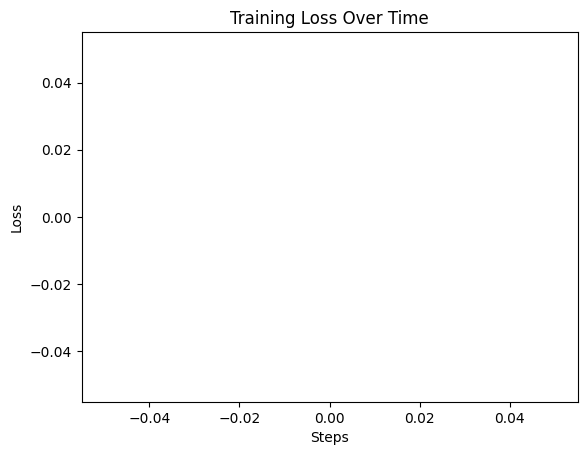

In [8]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

In [9]:
trainer.save_model()